/home/diego/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tabla guardada en subjects_roi_timepoints_stats.csv

Resumen N_timepoints:
count    352.000000
mean     180.252841
std       26.479606
min      140.000000
25%      140.000000
50%      197.000000
75%      197.000000
max      200.000000
Name: N_timepoints, dtype: float64

Resumen N_ROIs:
count    352.0
mean     116.0
std        0.0
min      116.0
25%      116.0
50%      116.0
75%      116.0
max      116.0
Name: N_ROIs, dtype: float64


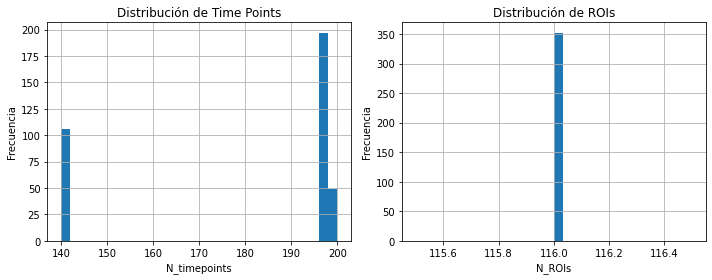

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.io as sio
from pathlib import Path
import matplotlib.pyplot as plt

# ==== CONFIGURACIÓN ====
subject_csv = '/home/diego/Escritorio/desde_cero/AAL_116/DataBaseSubjects.csv'
roi_signals_dir = '/home/diego/Escritorio/desde_cero/AAL_116/ROISignals'
roi_filename_template = 'ROISignals_{subject_id}.mat'
output_csv = 'subjects_roi_timepoints_stats.csv'

# ==== LEER LISTA DE SUJETOS ====
subjects_df = pd.read_csv(subject_csv)
subjects_df['SubjectID'] = subjects_df['SubjectID'].astype(str).str.strip()
subject_ids = subjects_df['SubjectID'].tolist()

# ==== RECORRER CADA SUJETO Y LEER .mat ====
results = []

for sid in subject_ids:
    mat_path = Path(roi_signals_dir) / roi_filename_template.format(subject_id=sid)
    if not mat_path.exists():
        print(f'[WARN] No encontrado: {mat_path}')
        continue
    try:
        data = sio.loadmat(mat_path)
        loaded_sigs = data.get("ROISignals", data.get("signals", data.get("roi_signals", data.get("ROIsignals")))
        )
        if loaded_sigs is None:
            print(f'[WARN] No señales en: {mat_path}')
            continue
        # Forzar matriz 2D
        if loaded_sigs.ndim == 1:
            loaded_sigs = loaded_sigs[:, np.newaxis]
        if loaded_sigs.shape[0] < loaded_sigs.shape[1] and loaded_sigs.shape[0] > 1:
            loaded_sigs = loaded_sigs.T
        T, N = loaded_sigs.shape
        results.append({'SubjectID': sid, 'N_timepoints': T, 'N_ROIs': N, 'mat_path': str(mat_path)})
    except Exception as e:
        print(f'[ERROR] {sid}: {e}')

# ==== CREAR DATAFRAME Y GUARDAR ====
res_df = pd.DataFrame(results)
res_df.to_csv(output_csv, index=False)
print(f'Tabla guardada en {output_csv}')

# ==== ESTADÍSTICA BÁSICA E HISTOGRAMAS ====
if not res_df.empty:
    print('\nResumen N_timepoints:')
    print(res_df['N_timepoints'].describe())
    print('\nResumen N_ROIs:')
    print(res_df['N_ROIs'].describe())

    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    res_df['N_timepoints'].hist(bins=30)
    plt.title('Distribución de Time Points')
    plt.xlabel('N_timepoints')
    plt.ylabel('Frecuencia')
    plt.subplot(1,2,2)
    res_df['N_ROIs'].hist(bins=30)
    plt.title('Distribución de ROIs')
    plt.xlabel('N_ROIs')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
else:
    print('No se encontraron datos para graficar.')

In [2]:
# Extract the top 3 N_timepoints from the histogram plot
top_3_timepoints = res_df['N_timepoints'].value_counts().head(3).index.tolist()
top_3_timepoints

[197, 140, 200]